In [2]:
import random
from prediction_analysis import *
from getting_examples import get_activation_data_for_feature
import concurrent.futures

In [7]:
import numpy as np
from openai import OpenAI
import re
import pprint
from getting_examples import get_activation_data_for_feature

def find_first_number(text):
    # Return the first number in a string
    match = re.search(r'\b\d+(\.\d+)?', text)
    return float(match.group(0)) if match else None

client = OpenAI()

def predict_activations(feature_index, test_number=20, show_examples=0):
    # Get and parse JSON data from the url corresponding to the requested feature
    url = f"https://www.neuronpedia.org/api/feature/gpt2-small/9-res-jb/{feature_index}"
    data = get_activation_data_for_feature(url)
    explanation = data['explanations'][0]['description']

    assert (len(data['examples']) >= (test_number + show_examples))

    # Randomly select some sentences to use as examples and test data
    random_indices = np.random.choice(len(data['examples']), size=test_number + show_examples, replace=False)
    sentences = [
        {
            'sentence_string': ''.join(data['examples'][i]['tokens']), 
            'activation':  data['examples'][i]['maxValue'], 
            'max_index': data['examples'][i]['maxValueTokenIndex']
         } 
        for i in random_indices]
    example_sentences = sentences[:show_examples]
    test_sentences = sentences[show_examples:] 

    highest_activation = data['examples'][0]['maxValue']

    # Create a system prompt dependning on how many example sentences are provided
    system_prompt = f'You are evaluating an english description of an autoencoder feature. The description should correspond to sentences which result in high activation. The english description of the feature is: "{explanation}"\n'

    if show_examples:
        system_prompt += f'Here are {show_examples} examples of sentences and their corresponding activations:\n '
        for sentence in example_sentences:
            sentence_string = sentence['sentence_string']
            activation = sentence['activation']
            system_prompt += f'Example: "{sentence_string}", Activation: {activation:.2f}\n'
        system_prompt += 'Use the provided samples and the provided description to predict the activation on a new sentence.'

    else:
        system_prompt += f'The value of the highest activation on the dataset is {highest_activation:.2f}. You must predict the activation on a new sentence based off of the provided description – if the description matches the provided sentence, the activation may be closer to {highest_activation:.2f}, while if it does not match the activation will be nearly 0.'

    system_prompt += '\nYou MUST respond with ONLY a number and NO OTHER content.'

    predictions = []

    # Have the model predict activations on each test sentence
    for sentence in test_sentences:
        sentence_string = sentence['sentence_string']
        user_message = f'Please predict the activation on this sentence, responding with a number between 0 and {highest_activation:.2f}.\n\nSentence: "{sentence_string}"'

        completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_message}
            ]
        )
        
        predicted = find_first_number(completion.choices[0].message.content)
        # (true, pred)
        predictions.append((sentence['activation'], predicted))

    return predictions

In [4]:
import matplotlib.pyplot as plt

### Losses
def mse(data, normalize = False):
    values = ([((elem[0]-elem[1])/(elem[0] if normalize else 1))**2 for elem in data])
    return sum(values)/len(values)

def nll_variant(data, eps = 1e-1):
    values = ([np.log((min(elem) + eps)/(max(elem) + eps)) for elem in data])
    return -sum(values)/len(values)

def l1(data, normalize = True, eps = 0.1):
    values = ([((eps + abs(elem[0]-elem[1]))/((max(elem) if normalize else 1) + eps))  for elem in data])
    return sum(values)/len(values)

### Plots
def plot_mses_cdf(mses):
    # Plotting the Mean Squared Errors (MSE) for each dataset
    mses_sorted = np.sort(mses)
    cdf = np.arange(1, len(mses_sorted)+1) / len(mses_sorted)
    plt.plot(mses_sorted, cdf)
    plt.title('Cumulative Distribution Function of MSEs')
    plt.xlabel('MSE')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.show()

def plot_probability_distribution(data, bins='auto', density=True, title = "Default Title"):
    """
    Plots the probability distribution of the given data using a histogram.

    Parameters:
    - data (list or numpy array): The floating point numbers whose distribution you want to plot.
    - bins (int, sequence or str, optional): The method for calculating histogram bins. Default is 'auto'.
    - density (bool, optional): If True, the histogram is normalized to form a probability density,
                                i.e., the area under the histogram will sum to 1. Default is True.
    """
    # Calculate the histogram
    counts, bin_edges = np.histogram(data, bins=bins, density=density)

    # Calculate bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plotting the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(bin_centers, counts*np.diff(bin_edges), align='center', width=np.diff(bin_edges), edgecolor='black', alpha=0.7)
    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.title('Probability Distribution of Data')
    plt.title(title)
    plt.grid(True)
    plt.show()

def analyze_data(all_data):
    mses = [mse(data, normalize = False) for data in all_data]
    nlls = [nll_variant(data) for data in all_data]
    l1s = [l1(data, normalize = True) for data in all_data]

    print('l1s', sorted(l1s))
    plot_probability_distribution(mses, title = "Distribution of MSEs")
    plot_probability_distribution(nlls, title = "Distribution of NLL variant")
    plot_probability_distribution(l1s, title = "Distribution of l1s variant")

l1s [0.5450832105597676, 0.5667038473098479, 0.5676871152466975, 0.6295966064670017, 0.6457357953464328, 0.720958064401499, 0.7234702929281227, 0.7327574277589057, 0.7456412980740218, 0.8676258711774784]


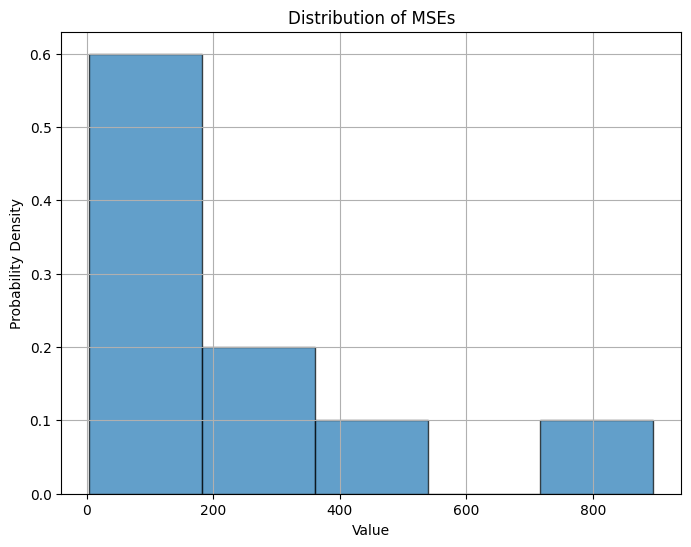

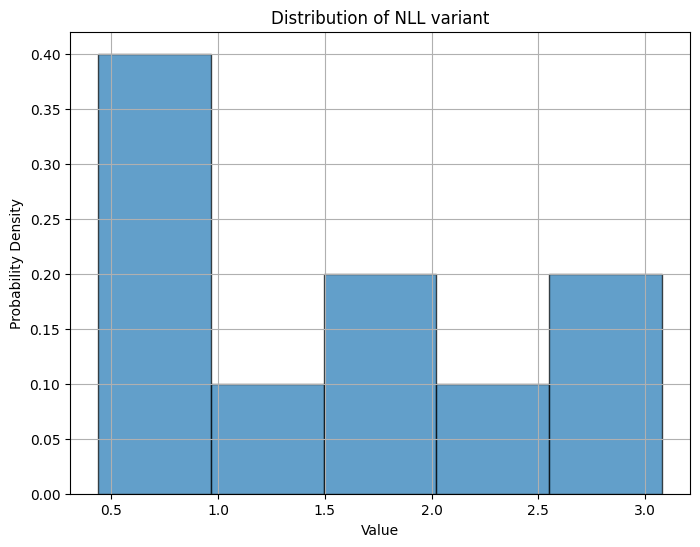

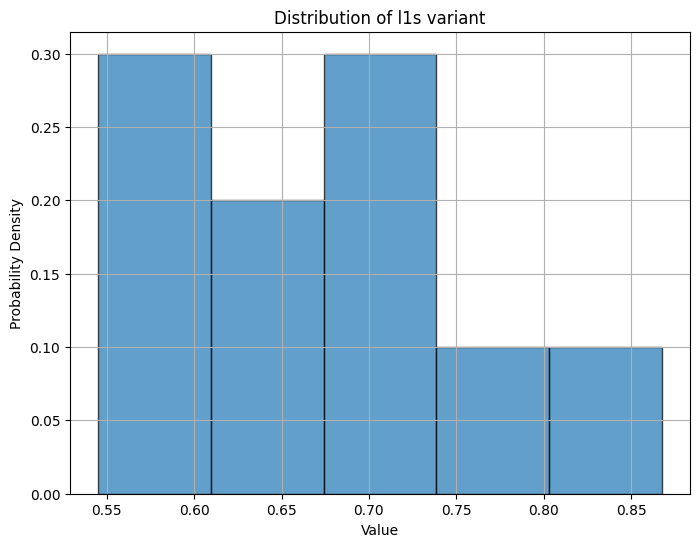

In [5]:
feature_nums = random.sample(range(0, 1000), 10)

def get_predictions(feature_num):
    # activation_data = get_activation_data_for_feature(f"https://www.neuronpedia.org/api/feature/gpt2-small/9-res-jb/{feature_num}")
    predictions = predict_activations(feature_num, test_number=10, show_examples=8)
    return predictions


with concurrent.futures.ThreadPoolExecutor() as executor:
    all_data = list(executor.map(get_predictions, feature_nums))

mses = [mse(data, normalize = False) for data in all_data]
nlls = [nll_variant(data) for data in all_data]
l1s = [l1(data, normalize = True) for data in all_data]

print('l1s', sorted(l1s))
plot_probability_distribution(mses, title = "Distribution of MSEs")
plot_probability_distribution(nlls, title = "Distribution of NLL variant")
plot_probability_distribution(l1s, title = "Distribution of l1s variant")

In [32]:
def custom_accuracy(data, eps = 0.1):
    values = []
    for elem in data:
        true, pred = elem
        ## Add eps to avoid zero case
        true, pred = true + eps, pred + eps
        # Scale values
        true, pred = true ** 0.75, pred ** 0.75
        # Calculate difference
        difference = abs(true - pred)
        # Take ratio
        error = difference / max(true, pred)
        
        accuracy = 1 - error
        values.append(accuracy)
    return sum(values)/len(values)

In [37]:
feature_nums

[343, 240, 406, 403, 382, 866, 610, 341, 94, 511]

343
[(3.237123250961304, 4.603228569030762),
 (16.25450706481934, 3.7259812355041504),
 (0.4013365507125854, 0.4013365507125854),
 (0.4013365507125854, 0.4013365507125854),
 (19.63329315185547, 9.283515930175781),
 (12.35690879821777, 5.302547454833984),
 (0.4013365507125854, 1.201336503982544),
 (17.49419784545898, 9.588321685791016),
 (3.67275333404541, 2.229865789413452),
 (0.4013365507125854, 0.4013365507125854)]
0.7041396002646838
240
[(0, 10.512874603271484),
 (0, 0.0),
 (1.708425164222717, 4.29674768447876),
 (11.11334991455078, 8.990189552307129),
 (0, 0.0),
 (0, 4.586930274963379),
 (0, 0.0),
 (6.676608562469482, 8.916431427001953),
 (0, 0.0),
 (1.293587565422058, 0.0)]
0.6399853054065971
406
[(21.51482963562012, 39.984596),
 (43.05316162109375, 42.083797454833984),
 (43.47838973999023, 41.2075080871582),
 (0, 0.0),
 (44.34666442871094, 33.601234436035156),
 (42.0706672668457, 11.056478500366211),
 (0, 0.0),
 (22.69357299804688, 9.11237621307373),
 (44.19124984741211, 42.52506

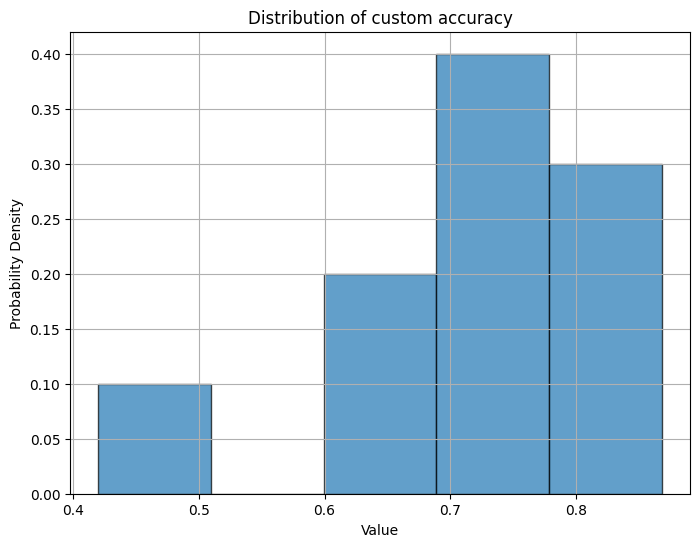

In [40]:
for i in range(len(all_data)):
    data = all_data[i]
    print(feature_nums[i])
    pprint.pprint(data)
    print(custom_accuracy(data))

custom = [custom_accuracy(data, eps = 0.1) for data in all_data]

plot_probability_distribution(custom, title = "Distribution of custom accuracy")

l1s [0.4341758310518763, 0.46944575051463744, 0.4705256960607837, 0.4945465426086112, 0.5164374137605235, 0.5733839172565047, 0.6713045541786157, 0.6803134000828931, 0.7640090835678086, 0.8069201017333434]


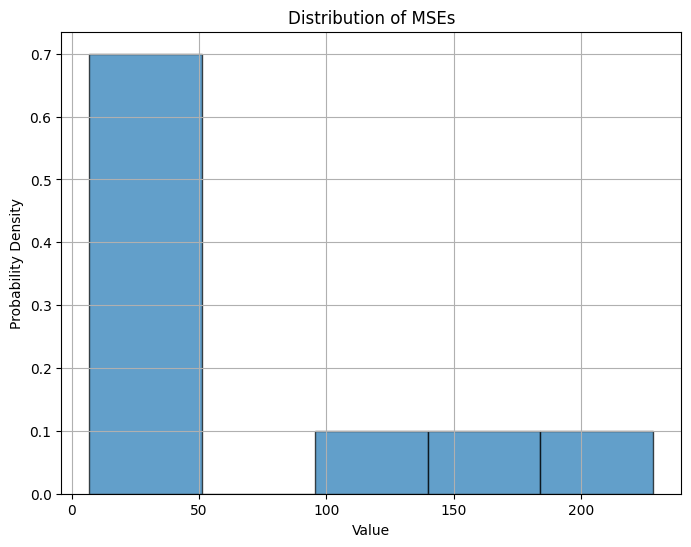

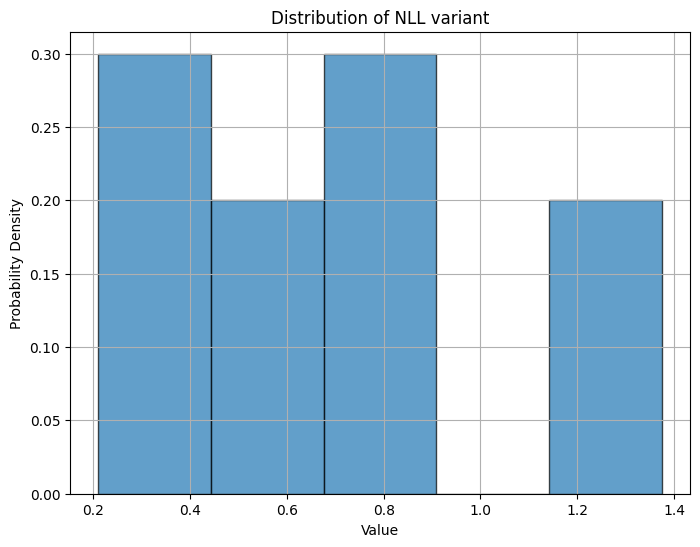

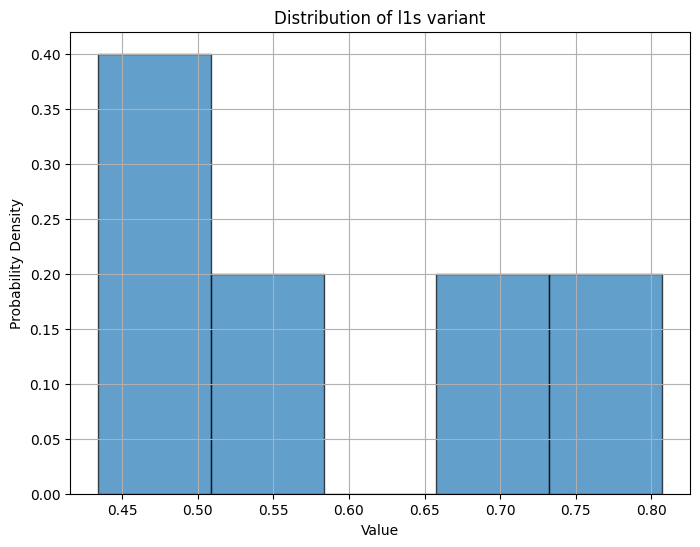

In [41]:
analyze_data(all_data)